In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.3, .3, .35, .05, 1], index=['ES','NQ', 'GC', 'CL', 'total'])
#allocs = pd.Series([2/3, 1/3, 1], index=['ES','NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/blotter/blotter_2020-03-22_21-46_week_7_27_mar.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])

In [4]:
df.groupby('contract').realizedPNL.sum()

contract
CL   -2278.44
ES   -3483.60
GC    7910.96
NQ   -5539.00
Name: realizedPNL, dtype: float64

In [5]:
df.realizedPNL.sum()

-3390.0800000000027

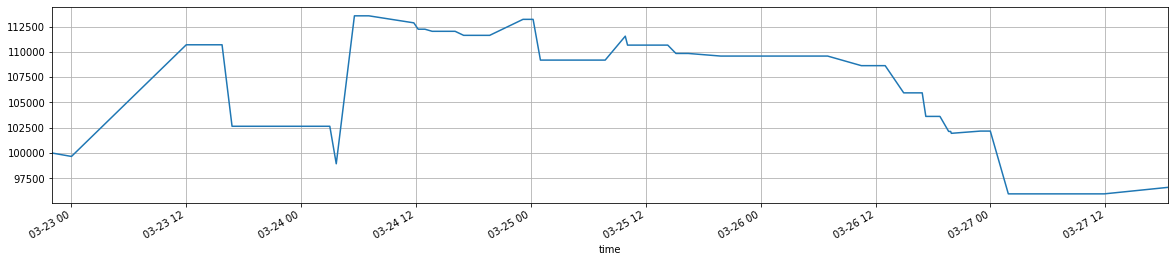

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [21]:
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
time,,,,,,,,,
2020-03-22 22:02:30.837934+00:00,CL,SELL,1.0,21.650,1208,ENTRY,2.37,0.00,100000.00
2020-03-23 00:03:18.693265+00:00,CL,BUY,1.0,21.980,1209,STOP-LOSS,2.37,-334.74,99665.26
2020-03-23 12:02:21.001718+00:00,ES,BUY,2.0,2253.250,998,STOP-LOSS,4.20,11041.60,110706.86
2020-03-23 12:06:31.015594+00:00,GC,BUY,2.0,1510.600,1019,ENTRY,4.84,0.00,110706.86
2020-03-23 15:46:30.761660+00:00,ES,SELL,2.0,2181.750,1021,ENTRY,4.20,0.00,110706.86
2020-03-23 16:49:06.368528+00:00,ES,BUY,2.0,2262.250,1022,STOP-LOSS,4.20,-8058.40,102648.46
2020-03-24 02:16:31.352880+00:00,CL,BUY,1.0,24.730,1041,ENTRY,2.37,0.00,102648.46
2020-03-24 03:01:32.302589+00:00,NQ,BUY,2.0,7240.500,1043,ENTRY,4.20,0.00,102648.46
2020-03-24 03:41:54.555508+00:00,NQ,SELL,2.0,7148.000,1044,STOP-LOSS,4.20,-3708.40,98940.06


In [35]:
df[(df['contract'] == 'GC')]

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
time,,,,,,,,,
2020-03-23 12:06:31.015594+00:00,GC,BUY,2.0,1510.6,1019,ENTRY,4.84,0.00,110706.86
2020-03-24 05:35:41.748974+00:00,GC,SELL,2.0,1583.8,1020,STOP-LOSS,4.84,14630.32,113570.38
2020-03-24 07:06:02.666563+00:00,GC,BUY,2.0,1601.2,1063,ENTRY,4.84,0.00,113570.38
2020-03-25 00:15:01.711792+00:00,GC,BUY,2.0,1692.5,1105,ENTRY,4.84,0.00,113222.04
2020-03-25 01:00:56.421895+00:00,GC,SELL,2.0,1672.4,1106,STOP-LOSS,4.84,-4029.68,109192.36
2020-03-26 13:00:31.261437+00:00,GC,BUY,2.0,1663.6,1105,ENTRY,4.84,0.00,108642.68
2020-03-26 14:56:33.397500+00:00,GC,SELL,2.0,1650.2,1106,STOP-LOSS,4.84,-2689.68,105953.00
2020-03-27 11:45:32.527272+00:00,GC,SELL,2.0,1617.1,1105,ENTRY,4.84,0.00,95964.66


In [8]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL    12
ES     7
GC     8
NQ    20
Name: action, dtype: int64

In [9]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL    28.44
ES    29.40
GC    38.72
NQ    84.00
Name: commission, dtype: float64

In [10]:
df.commission.sum()

180.55999999999997

In [11]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
CL,0.17,-379.74,645.26,-584.74,1.10,-375.64,6.0
ES,0.25,-870.90,11041.60,-4841.73,2.28,-870.90,4.0
NQ,0.30,-553.90,1389.93,-1386.97,1.00,-553.90,10.0
GC,0.33,2636.99,14630.32,-3359.68,4.35,2577.02,3.0
total,0.26,-147.39,5081.16,-1992.77,2.55,-153.55,23.0


In [12]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [13]:
# instrument correlations
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

,CL,ES,GC,NQ,total
CL,1.000000,-0.555150,0.101563,-0.319989,-0.153363
ES,-0.555150,1.000000,0.072006,-0.124151,0.440157
GC,0.101563,0.072006,1.000000,-0.415064,0.873320
NQ,-0.319989,-0.124151,-0.415064,1.000000,-0.137139
total,-0.153363,0.440157,0.873320,-0.137139,1.000000


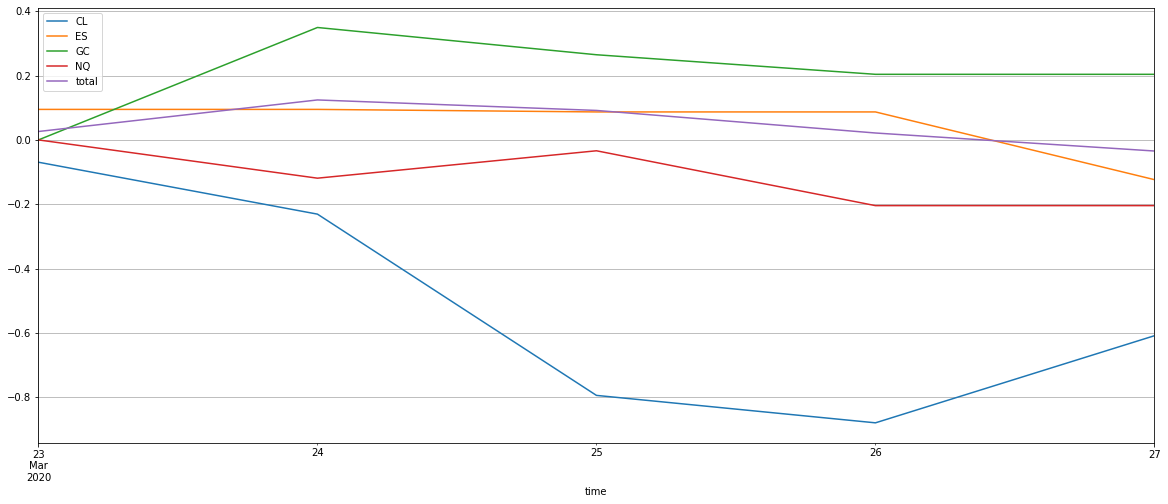

In [14]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

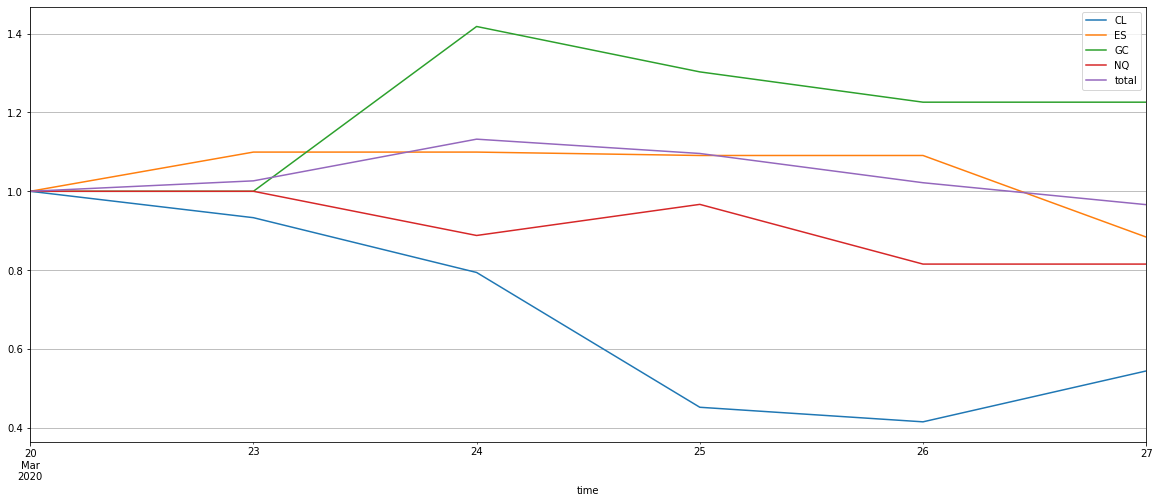

In [15]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [16]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,CL,ES,GC,NQ,total
Annual return,-1.000000,-0.994396,5211.041008,-0.999811,-0.765084
Cumulative returns,-0.455688,-0.116120,0.226027,-0.184633,-0.033901
Annual volatility,3.798311,1.494859,2.943752,1.412726,0.998580
Sharpe ratio,-4.614763,-2.756520,3.963967,-5.347632,-1.039442
Calmar ratio,-1.710162,-5.071806,38489.622933,-5.415116,-5.214529
Stability,0.721900,0.155213,0.337342,0.741270,0.039342
Max drawdown,-0.584740,-0.196063,-0.135388,-0.184633,-0.146722
Omega ratio,0.426820,0.503367,2.982003,0.330618,0.839737
Sortino ratio,-5.783480,-3.348606,17.941542,-6.052247,-1.729609
Skew,0.124908,-0.956148,1.642902,-0.257146,0.749845


In [17]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,CL,ES,GC,NQ,total
time,,,,,
2020-03-31 00:00:00+00:00,-45.57,-11.61,22.6,-18.46,-3.39


In [18]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

CL      -46.0
ES      -12.0
GC       23.0
NQ      -18.0
total    -3.0
dtype: float64

In [19]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-03-24 05:35:41.748974+00:00,GC,SELL,1583.800,14630.32
2020-03-23 12:02:21.001718+00:00,ES,BUY,2253.250,11041.60
2020-03-25 09:52:24.542290+00:00,NQ,SELL,7671.000,2366.60
2020-03-24 23:11:43.331915+00:00,NQ,SELL,7549.000,1581.60
2020-03-27 18:33:22.658070+00:00,CL,BUY,21.710,645.26
2020-03-26 22:57:26.730511+00:00,NQ,SELL,7821.750,221.60
2020-03-26 23:59:01.701024+00:00,ES,BUY,2631.000,0.00
2020-03-26 19:50:30.722337+00:00,NQ,BUY,7816.000,0.00
2020-03-26 18:43:30.831244+00:00,NQ,BUY,7762.000,0.00
